In [49]:
import nltk
from nltk.stem import *
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn

lemmatizer = WordNetLemmatizer()
row = "AUDUSD"
#Convert between the PennTreebank tags to simple Wordnet tags
def convertWN(tag):

    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None
 
sentiment = 0.0
tagged=nltk.pos_tag(nltk.word_tokenize(row))
print("Tweet:", row)
print()
print("POS: ", tagged)

for word, tag in tagged:
    wnTag = convertWN(tag)
    if wnTag not in (wn.NOUN, wn.ADJ, wn.ADV):
        continue
 
    lemma = lemmatizer.lemmatize(word, pos=wnTag)
    print("Lemma: ", lemma)

    if not lemma:
        continue
 
    synsets = wn.synsets(lemma, pos=wnTag)
    print(synsets)
    if not synsets:
        continue
    
    # Take the first sense, the most common
    synset = synsets[0]
    swnscore = swn.senti_synset(synset.name())
    sentiment += (swnscore.pos_score() - swnscore.neg_score())
    print(" ")
print("Sentiment: ", swnscore)
    


Tweet: AUDUSD

POS:  [('AUDUSD', 'NN')]
Lemma:  AUDUSD
[]


In [290]:
### Perform SentiWordNet sentiment analysis on Twitter Data from the last week of October
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import sentiwordnet as swn
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn

filename = '/Users/mitalipalsikar/Documents/year3project/Daily Twitter/twitterData1.csv'
df = pd.read_csv(filename, encoding='utf-8')

#take values of last week of October
df = df[(df['Timestamp'] > '2017-10-13 00:00:00') & (df['Timestamp'] < '2017-10-27 23:00:00')]
import pandas as pd
from pandas.tseries.offsets import BDay
isBusinessDay = BDay().onOffset
match_series = pd.to_datetime(df['Timestamp']).map(isBusinessDay)
df = df[match_series]
svalues = []
lvalues=[]
lemmatizer = WordNetLemmatizer()

#Convert between the PennTreebank tags to simple Wordnet tags
def convertWN(tag):

    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None

#Break tweet into synsets and get score of each sentence
def swnSentiment(sentence):
    sentiment = 0.0
    tagged=nltk.pos_tag(nltk.word_tokenize(sentence))
    for word, tag in tagged:
        wnTag = convertWN(tag)
        if wnTag not in (wn.NOUN, wn.ADJ, wn.ADV):
            continue
 
        lemma = lemmatizer.lemmatize(word, pos=wnTag)
        if not lemma:
            continue

        synsets = wn.synsets(lemma, pos=wnTag)
        if not synsets:
            continue
        # Take the first sense, the most common
        synset = synsets[0]
        swnscore = swn.senti_synset(synset.name())
        sentiment += (swnscore.pos_score() - swnscore.neg_score())

    return sentiment

#iterate through each row of df and get tweet
def sentiWordNet():
    i = 0;
    fsentiment = 0.0
    for row in df.values:
        sentence = row[5]
        sd = {}
        date = row[0]
        fsentiment = swnSentiment(sentence);
        sd['Tweet'] = sentence
        sd['Date'] = date
        sd['Sentiment'] = fsentiment
        svalues.append(sd)
    sdf = pd.DataFrame(svalues)
    print("Finished sentiment analysis for Dataset")
    return sdf

def vaderSentiment():

    sid = SentimentIntensityAnalyzer()
    i = 0;
    for row in df.values:
        sentence = row[5]
        date = row[0]
        ss = sid.polarity_scores(sentence)    
        ss['Tweet'] = sentence
        ss['Date'] = date
        lvalues.append(ss)

    vdf = pd.DataFrame(lvalues)
    print("Finished sentiment analysis for Dataset")
    return vdf
#sdf = sentiWordNet()
sdf = vaderSentiment()

Finished sentiment analysis for Dataset


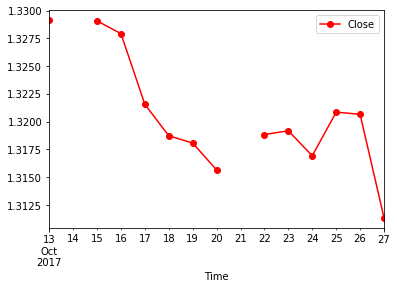

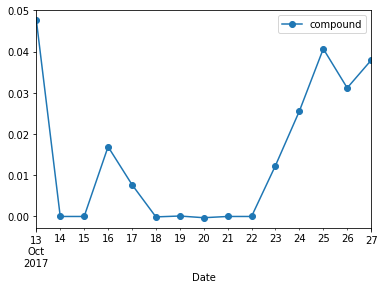

In [291]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
fxFile = '/Users/mitalipalsikar/Documents/year3project/Daily Rates/fxhistoricaldataGBPUSD.csv'

#Get sentiment analysis for all tweets talking about $GBPUSD
gbpusd = sdf[sdf['Tweet'].str.contains("GBPUSD") ]
#drange = pd.date_range('2017-10-23', '2017-10-27', freq='60min')
gbpusd.set_index('Date', inplace=True)
gbpusd.index = pd.to_datetime(gbpusd.index)

fx = pd.read_csv(fxFile)
#FX values for GBPUSD for same date range
fx = fx[(fx['Time'] >= '2017-10-13') & (fx['Time'] < '2017-10-28 00:00:00')]
fx.set_index('Time', inplace=True)
fx.index = pd.to_datetime(fx.index)
#fx = fx.sort_values('Time')

def plotChanges( fxval, senval):
 
    
    senval= senval.resample('D').mean()
    fxval= fxval.resample('D').mean()
    
    senval['% Sentiment'] = senval['compound'].pct_change()   
    senval = senval.fillna(0)
    fxval['% Close Price'] = fxval['Close'].pct_change() 
    fxval.fillna(method='ffill')
    fxfig = fxval.plot( y = 'Close', marker='o', color='r', use_index=True)
    swnfig = senval.plot( y = 'compound', marker='o', use_index=True)
    fxfig.get_figure().savefig('/Users/mitalipalsikar/Documents/year3project/presentation1/demoGBPUSD2.png')
    swnfig.get_figure().savefig('/Users/mitalipalsikar/Documents/year3project/presentation1/demovdf.png')

plotChanges(fx, gbpusd)

In [288]:
import pandas as pd
from pandas.tseries.offsets import BDay

isBusinessDay = BDay().onOffset
match_series = pd.to_datetime(sdf['Date']).map(isBusinessDay)

sdf[match_series]


,Date,Tweet,compound,neg,neu,pos,% Sentiment
0,2017-10-13 00:00:52,GBPUSD close major resistance prepare sell for...,0.0000,0.000,1.000,0.000,0.000000
1,2017-10-13 00:05:39,GBPUSD Price test best opportuniti LONG chart,0.6369,0.000,0.588,0.412,inf
2,2017-10-13 00:05:39,GBPUSD Price test u2026,0.0000,0.000,1.000,0.000,-1.000000
3,2017-10-13 00:07:33,USDJPY chart via,0.0000,0.000,1.000,0.000,0.000000
4,2017-10-13 00:07:34,USDJPY BUY STOP,-0.2960,0.524,0.476,0.000,-inf
5,2017-10-13 00:07:59,usdcad USDCAD,0.0000,0.000,1.000,0.000,-1.000000
6,2017-10-13 00:08:31,USDJPY BUY STOP FXY,-0.2960,0.423,0.577,0.000,-inf
7,2017-10-13 00:10:29,GBP jumps report UK might offered 2 year Brexi...,0.0000,0.000,1.000,0.000,-1.000000
8,2017-10-13 00:10:30,GBPUSD Price test best opportuniti LONG GBP FXB,0.6369,0.000,0.625,0.375,inf
9,2017-10-13 00:10:38,Technical Analysis USDCAD 1h SHO TERM chart,0.0000,0.000,1.000,0.000,-1.000000
